참고
* [https://www.kaggle.com/bertcarremans/data-preparation-exploration](https://www.kaggle.com/bertcarremans/data-preparation-exploration)
* [https://www.kaggle.com/jeanbai/resampling-strategies-for-imbalanced-datasets](https://www.kaggle.com/jeanbai/resampling-strategies-for-imbalanced-datasets)
* [https://www.kaggle.com/whtngus4759/porto-seguro-for-beginner](https://www.kaggle.com/whtngus4759/porto-seguro-for-beginner)
* [https://www.kaggle.com/kongnyooong/porto-seguro-eda-for-korean](https://www.kaggle.com/kongnyooong/porto-seguro-eda-for-korean)
* [https://www.kaggle.com/vprokopev/mean-likelihood-encodings-a-comprehensive-study](https://www.kaggle.com/vprokopev/mean-likelihood-encodings-a-comprehensive-study)
* [https://www.kaggle.com/werooring/top-9th-lightgbm-xgboost-ensemble](https://www.kaggle.com/werooring/top-9th-lightgbm-xgboost-ensemble)

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier

> # 데이터 탐색

## data loading

In [ ]:
train = pd.read_csv('../input/porto-seguro-safe-driver-prediction/train.csv')
test = pd.read_csv('../input/porto-seguro-safe-driver-prediction/test.csv')

## data head-5 데이터 보기

In [ ]:
print(train.head())

## data tail-5 데이터 보기

In [ ]:
print(train.tail())

## shape 보기

In [ ]:
print(train.shape)

## 중복된 row가 있는지 확인하기 (완전히 같은 데이터가 있는지 확인)

In [ ]:
train.drop_duplicates()
print(train.shape)

중복된 row가 없음을 알 수 있다.

## test data 에 train data와 같은 variable(column) 의 수를 가지고 있는지 확인

In [ ]:
print(test.shape)

하나가 누락 돼 있는 것 처럼 보이지만, target 값이 누락 돼 있는거여서 괜찮다.

## 각각의 variable에 대한 정보 가져오기

null 값이 -1로 대채 돼 있어서 null 값이 없다고 나옴. <br>
binary 값은 이미 수로 변환돼 있음. <br>
이후에 categorical feature 들로 dummy variable 만들 필요 있음. <br>

In [ ]:
print(train.info())

# Meta Data

데이터 관리를 용이하게 하기 위해서 변수에대한 meta정보를 DataFrame에 저장 할 것이다. <br>
이는 이후 분석, 시각화, 모델링시에 유용하다. 

* role: input, ID, target -> 역할 <br>
* level: nominal, interval, ordinal, binary -> 데이터 종류 <br>
* keep: True or False <br>
* dtype: int, float, str

In [ ]:
data = []

for f in train.columns:
    if f == 'target':
        role = 'target'
    elif f == 'id':
        role = 'id'
    else:
        role = 'input'

    if 'bin' in f or f == 'target':
        level = 'binary'
    elif 'cat' in f or f == 'id':
        level = 'nominal'
    elif train[f].dtype == 'float64':
        level = 'interval'
    elif train[f].dtype == 'int64':
        level = 'ordinal'
        
    keep = True
    if f == 'id':
        keep = False
    
    dtype = train[f].dtype
    
    f_dict = {
        'varname':f,
        'role':role,
        'level':level,
        'keep':keep,
        'dtype':dtype
    }
    
    data.append(f_dict)
    
meta = pd.DataFrame(data, columns=['varname', 'role','level','keep', 'dtype'])
meta.set_index('varname', inplace=True)
meta.to_csv('./meta.csv')

## meta 데이터 사용해보는 연습

data 종류가 nomial 이고, drop 하지 않는 인덱스 추출

In [ ]:
meta[(meta.level == 'nomial') & (meta.keep)].index

role 과 level 에 따른 개수

In [ ]:
pd.DataFrame({'count':meta.groupby(['role', 'level'])['role'].size()}).reset_index()

## Meta Data 이용해서 describe() 적용할 변수 뽑기

describe 를 이용해서 평균, 표준편차 등등을 계산할 수 있지만, categorical variable 에 대해서 이러한 계산은 의미가 없다. <br>
그러므로, 이후에 categorical variable은 시각화한다.

In [ ]:
v = meta[(meta.level=='interval') & (meta.keep)].index # 인덱스 추출

train[v].describe()


## insight 1

1. 이를 통해 평균과 중앙값의 차이, 최소 최대를 보아 데이터가 어떤 식의 분포를 가지고 있는지 대충 추정할 수 있다.
2. 최소값을 관찰하여 최소값이 -1이 존재하는 column에 결측치가 있음을 알 수 있다.

### reg variable 에 대한 insight

* ps_reg_03 만 missing values를 가지고 있다.
* reg 변수간의 최대 최소 사이 범위가 서로 다르기 때문에 scaling을 사용해 볼 수 있다.
* 그러나, 우리가 사용하고자 하는 classifier에 따라서 scaling 사용 여부/어떤 scaling을 사용할 지 달라진다.

<br>

#### scaler 별 효과
https://homeproject.tistory.com/entry/%EB%8D%B0%EC%9D%B4%ED%84%B0-%EC%8A%A4%EC%BC%80%EC%9D%BC%EB%A7%81-Data-Scaling

In [ ]:
'''
           ps_reg_01      ps_reg_02      ps_reg_03      
count  595212.000000  595212.000000  595212.000000     
mean        0.610991       0.439184       0.551102         
std         0.287643       0.404264       0.793506       
min         0.000000       0.000000      -1.000000      
25%         0.400000       0.200000       0.525000      
50%         0.700000       0.300000       0.720677       
75%         0.900000       0.600000       1.000000       
max         0.900000       1.800000       4.037945       
'''

### car variable 에 대한 insight

* ps_car_12, ps_car_14 가 missing data를 가지고 있고
* 최대 최소 사이 범위가 다르기 때문에 scaling 적용 가능

In [ ]:
'''
           ps_car_13      ps_car_14      ps_car_15 
count  595212.000000  595212.000000  595212.000000    
mean        0.813265       0.276256       3.065899       
std         0.224588       0.357154       0.731366       
min         0.250619      -1.000000       0.000000   
25%         0.670867       0.333167       2.828427        
50%         0.765811       0.368782       3.316625        
75%         0.906190       0.396485       3.605551 
max         3.720626       0.636396       3.741657       

'''

### calc variable 에 대한 insight

* missin data는 없음.
* 최대값이 0.9임을 알 수 있다.
* 3개의 _calc 변수들이 같은 분포를 가지고 있음을 알 수 있다.

In [ ]:
'''
          ps_calc_02     ps_calc_03  
count  595212.000000  595212.000000  
mean        0.449589       0.449849  
std         0.286893       0.287153  
min         0.000000       0.000000  
25%         0.200000       0.200000  
50%         0.400000       0.500000  
75%         0.700000       0.700000  
max         0.900000       0.900000  
'''

## insight 2

* 전반적으로, interval 변수들의 범위가 크게 차이가 나지 않는 것으로 보아, 아마도 log 변환 같은 데이터 변환이 적용된 데이터이지 아닐까 생각한다.


## categorical variable 에 대한 describe

앞에서 categorical variable 에 대해서 이러한 계산은 무의미하다고 했으나, 그래도 한 번 describe를 통해 관찰해 본다.

### 1. ordinal variables 

In [ ]:
v = meta[(meta.level=='ordinal') & (meta.keep)].index # 인덱스 추출

train[v].describe()

### insight

* ps_car_11 만 결측치가 존재함을 알 수 있다.
* 다른 범위를 가지고 있을 경우 scaling 적용 가능 

### 2. binary variables

In [ ]:
v = meta[(meta.level=='binary') & (meta.keep)].index

train[v].describe()

### insight

* 평균을 통해 대부분의 변수에서 값들이 0임을 알 수 있고, 이는 매우 imbalance한 데이터 임을 알 수 있다.

# imabalaced classes 다루기


targert=1 인 것의 비율이 target=0 보다 매우 적다. <br>
이로 인해 accuracy가 좋아 보일 수는 있으나, 사실 그렇게 볼 수는 없고 모델의 학습이 제대로 이루어지지 않을 확률이 높다. <br>
<br>
이를 해결하기 위해 나온 개념이 under-sampling 과 over-sampling 이다.
<br>


* under-sampling: 불균형한 데이터 셋에서 높은 비율을 차지하던 클래스의 수를 줄임으로써 데이터의 불균형을 해소하는 아이디어이다. <br>
  하지만, 이 방법은 학습에 사용되는 전체 데이터 수를 급격하게 감소시켜 오히려 성능이 떨어질 수 있다.
<br>

* over-sampling: 낮은 비율 클래스의 데이터 수를 늘림으로써 데이터 불균형을 해소하는 아이디어이다. <br>
  이 방법은 가능하다면 언더 샘플링보다 훨씬 좋은 해결책이지만, 문제는 어떻게 없던 데이터를 생성하느냐 이다.

## 여러가지 imbalanced classes 다루는 방법

### 출력과 시각화를 통해 데이터가 매우 imbalance 함을 알 수 있다.

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_train = pd.read_csv('../input/porto-seguro-safe-driver-prediction/train.csv')

target_count = df_train.target.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

plt.title('Count (target)')
sns.countplot(x='target', data=df_train)
plt.show()

### metric 함정

초보자가 불균형 데이터 세트를 처리할 때 발생하는 주요 문제 중 하나는 모델을 평가하는데 사용되는 metric과 관련이 있다. <br>
accuracy_score 와 같은 더 간단한 측정 항목을 사용하면 오해의 소지가 생긴다.<br>
분류기가 학습을 하지 않고 가장 수가 많은 class를 예측하면, 여전히 높은 정확도를 갖게 된다.<br>

예를 들어 100개의 데이터 중 96개가 1이고 4개가 0인데, 분류기는 그냥 모든 데이터를 1로 예측했을 뿐인데 96% 의 정확도가 나오는 것이다.

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Remove 'id' and 'target' columns
labels = df_train.columns[2:]

X = df_train[labels]
y = df_train['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

하나의 feature 만을 사용해서 accuracy가 어떻게 나오는 지 봤다.

In [ ]:
model = XGBClassifier()
model.fit(X_train[['ps_calc_01']], y_train)
y_pred = model.predict(X_test[['ps_calc_01']])

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

위와 아래 결과 모두 96.35% 정확도를 보인다. 역시 높은 정확도는 그저 착각이었다. <br>
불균형 데이터 세트에 사용되는 metric 을 선택하는 것은 매우 중요하다. <br>

이 competition에서 evaluation metric은 불균형 데이터 세트에 대해 보다 강력한 <br>
metric인 정규화된 지니 계수이며, random guessing(무작위 추측)의 경우 약 0에서 최고점의 경우 약 0.5까지이다. <br>

### confusion matrix

xgboost에 의해 예측이 어떻게 됐는지 보기 위해 confusion matrix 를 본다

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']

fig = plt.figure()
ax = fig.add_subplot(111)
sns.heatmap(conf_mat,cmap=plt.cm.Blues)
ax.set_xlabel([''] + labels)
ax.set_ylabel([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

* 분류기가 모든 데이터를 1로 예측 했다는 것을 알 수 있다.
* 모든 데이터를 1로 예측 했음에도 96% 의 accuracy 가 나왔음을 알 수 있다.

## Resampling

매우 불균형한 데이터를 처리하기 위해 널리 채택되는 기술을 Resampling 이라고 한다. <br>
다수 클래스에서 샘플을 제거하거나(under-sampling) 소수 클래스에서 더 많은 example 을 추가하는 방식(over-sampling)이 있다. <br>
<br>

sampling을 통해 balancing class 들을 만들어 준다는 장점이 있지만 단점도 존재한다. <br>
* over-sampling은 소수의 클래스에서 임의의 record(행) 을 복제하기 때문에 over-fitting을 유발한다. <br>
* under-sampling은 다수의 클래스에서 임의의 record를 제거하는 것이므로 정보 손실이 발생할 수 있다. <br>

### DataFream.sample 을 이용하여 각 클래스에 대해 random sample을 얻는 방법

In [ ]:
# 각 class별 개수 count
count_class_0, count_class_1 = df_train.target.value_counts()

df_class_0 = df_train[df_train['target'] == 0]
df_class_1 = df_train[df_train['target'] == 1]

print(count_class_0)
print(count_class_1)

## 1. Random under sampling


pandas.DataFrame.sample: <br>

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sample.html <br>

-> Return a random sample of items from an axis of object. <br>

In [ ]:
# target 이 1인 데이터 개수만큼 sampling
# df_class_0 에서 count_class_1 개수 만큼의 수로 sampling 해서 그 데이터만 가지고 train data를 다시 구성
df_class_0_under = df_class_0.sample(n=count_class_1)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_test_under.target.value_counts())

In [ ]:
sns.countplot(x=df_test_under['target'])
plt.title('Count (target)')
plt.show()

## 2. Random over-sampling

In [ ]:
# 데이터가 적은 df_class_1 의 데이터를 중복을 허용하여 count_class_0 만큼의 수로 sampling
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_test_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_test_over.target.value_counts())

In [ ]:
sns.countplot(x=df_test_over['target'])
plt.title('Count (target)')
plt.show()

### Python imbalanced-learn module

scientific literature 에서는 보다 정교한 Resampling 기법이 많이 제안되었다. <br>
<br>
에를들어, 
* under-sampling 의 경우 
  다수 클래스의 record(행 데이터)를 clustering 하고 각 cluster 에서 record를 제거하여 under-sampling을 수행하여정보를 보존할 수 있다. 

* over-sampling 의 경우
  소수 클래스 record 의 정확한 복수본을 만드는 대신 복사본에 작은 변형을 도입하여 더 다양한 합성 샘플을 만들 수 있다.

Python 라이브러리 imbalanced-learn을 사용하여 이러한 Resampling 기술 중 일부를 적용 해 볼 수 있다. <br>
scikit-learn과 호환되며 scikit-learn-contrib 프로젝트의 일부입니다. <br>

<br>
anaconda prompt 에서 <br>

pip install imblearn 을 통해 다운 받는다. <br>

가상 환경을 만들어서 쓰고 있다면 'activate 가성환경 이름' 으로 가상환경 활성화를 시키고 설치하면 된다. <br>

------------------------------------------------------------------------------------ <br>

여기서 부터는 Porto Seguro’s Safe Driver Prediction 을 사용하지 않고 잠시 임의의 데이터를 만들어서 사용한다. <br>
사용 예시를 보여주기 위함이다.

In [ ]:
# make_classification method 를 이용해 임의의 작은 unbalanced data 를 만들어준다.
from sklearn.datasets import make_classification

X, y = make_classification(
    n_classes=2, class_sep=1.5, weights=[0.9, 0.1],
    n_informative=3, n_redundant=1, flip_y=0,
    n_features=20, n_clusters_per_class=1,
    n_samples=100, random_state=10
)

df = pd.DataFrame(X)
df['target'] = y
df.target.value_counts().plot(kind='bar', title='Count (target)')
plt.show()

In [ ]:
# 시각화를 위한 함수

import numpy as np

def plot_2d_space(X, y, label='Classes'):
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

임의로 만든 데이터가 고차원 데이터이기 때문에 PCA를 이용하여 2차원으로 차원 축소를 해준다.

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X = pca.fit_transform(X)

plot_2d_space(X, y, 'Imbalanced dataset (2 PCA components)')

### 1) imblearn 을 이용해 under-sampling 을 수행한다.

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler()
X_rus, y_rus = rus.fit_resample(X,y)

print('Removed indexes:', rus.sample_indices_)

plot_2d_space(X_rus, y_rus, 'Random under-sampling')

### 2) imblearn 을 이용해 over-sampling 을 수행한다.

In [ ]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
X_ros, y_ros = ros.fit_resample(X, y)

print(X_ros.shape[0] - X.shape[0], 'new random picked points')

plot_2d_space(X_ros, y_ros, 'Random over-sampling')

### 3) Under-sampling: Tomek links

Tomek links 는 매우 가까운 instance 쌍이지만 반대 클래스이다. <br>
각 쌍의 다수 클래스 인스턴스를 제거하면 두 클래스 사이의 공간이 늘어나 classification에 용이해 진다. <br>
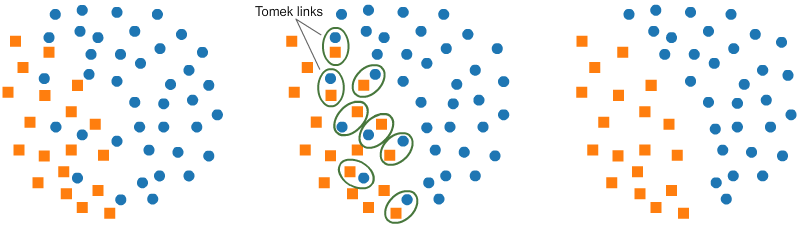

<br>
sampling_strategy='majority' 를 이용해서 구현한다.<br>

In [ ]:
from imblearn.under_sampling import TomekLinks

tl = TomekLinks(sampling_strategy='majority')

X_tl, y_tl = tl.fit_resample(X, y)

print('Removed indexes:', tl.sample_indices_)

plot_2d_space(X_tl, y_tl, 'Tomek links under-sampling')

### 4) Under-sampling: Cluster Centroids

이 기술은 clustering 방법을 기반으로 centroid를 생성하여 under-sampling을 수행한다. <br>
정보를 보존하기 위해 데이터는 유사성에 따라 그룹화 된다.<br>

<br>
아래 예시에서 sampling_strategy parameter 로 {0: 10} 딕셔너리를 넘겨주는데, 이는 다수 클래스인 0을 10개만 남기고, 소수 클래수 1은 그대로 둔다.

In [ ]:
from imblearn.under_sampling import ClusterCentroids

cc = ClusterCentroids(sampling_strategy={0:10})
X_cc, y_cc = cc.fit_resample(X, y)

plot_2d_space(X_cc, y_cc, 'Cluster Centroids under-sampling')

### 5) Over-sampling: SMOTE

SMOTE는 적은 데이터 셋에 있는 개별 데이터들의 K 최근접 아웃(K Nearest Neighbor)을 찾아서, <br>
이 데이터와 K개 이웃들의 차이를 일정 값으로 만들어서 기존 데이터와 약간 차이가 나는 새로운 데이터들을 생성하는 방식이다.
<br>

*  알고리즘

    1. 소수 데이터 중 특정 벡터 (샘플)와 가장 가까운 이웃 사이의 차이를 계산한다.
    2. 이 차이에 0과 1사이의 난수를 곱한다.
    3. 타겟 벡터에 추가한다.
    4. 두 개의 특정 기능 사이의 선분을 따라 임의의 점을 선택할 수 있다.

출처:
https://mkjjo.github.io/python/2019/01/04/smote_duplicate.html

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_resample(X, y)

plot_2d_space(X_sm, y_sm, 'SMOTE over-sampling')

### 6) Over-sampling followed by under-sampling

SMOTE 과 Tomek links 기술을 사용하여 over-sampling 과 under-sampling 의 조합을 수행한다.

In [ ]:
from imblearn.combine import SMOTETomek

smt = SMOTETomek()
X_smt, y_smt = smt.fit_resample(X, y)

plot_2d_space(X_smt, y_smt, 'SMOTE + Tomek links')

# 다시 돌아와서
### 여기서는 큰 training set을 사용하기 때문에, undersampling을 이용한다.

In [ ]:
desired_apriori=0.10

# 각 target 값에 대한 index 가져오기
idx_0 = train[train.target == 0].index
idx_1 = train[train.target == 1].index

# target 값에 대한 개수 가져오기
nb_0 = len(train.loc[idx_0])
nb_1 = len(train.loc[idx_1])



# Calculate the undersampling rate and resulting number of records with target = 0
undersampling_rate = ((1-desired_apriori)*nb_1)/(nb_0*desired_apriori)
# 위 식이 어떻게 나왔는 지 잘 모르겠음...
undersampled_nb_0 = int(undersampling_rate*nb_0)
print('Rate to undersample records with target=0: {}'.format(undersampling_rate))
print('Number of records with target=0 after undersampling: {}'.format(undersampled_nb_0))

# undersampled_nb_0 개수만큼 class 0 의 index 뽑기
undersampled_idx = shuffle(idx_0, random_state=37, n_samples=undersampled_nb_0)

# train 으로 쓸 index 리스트로 만들어서 합치기
idx_list = list(undersampled_idx) + list(idx_1)

# train 에서 index를 뽑아 새로운 train data 만들기
train = train.loc[idx_list].reset_index(drop=True)

# Data Quality Checks

## 1. 결측치 보기

In [ ]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.target.values


vars_with_missing = []

for f in train.columns:
    # train[f] == -1 인 데이터 프레임의 [f] column에서 데이터 개수를 count
    missing = train[train[f] == -1][f].count()

    if missing > 0:
        vars_with_missing.append(f)
        missing_perc = missing / train.shape[0]

        print('Variable {} has {} records ({:.2%}) with missing values'.format(f, missing, missing_perc))

print('In total, there are {} variables with missing values'.format(len(vars_with_missing)))

* ps_car_03_cat, ps_car_05_cat : 결측치가 너무 많아 지워버린다.

* 결측값이 있는 다른 categorical 데이터의 경우 결측값 -1 을 그대로 둘 수 있다.

* ps_reg_03 (continuous): 18% 의 결측치가 있다. 평균으로 채워준다.
* ps_car_11 (ordinal) : 5개의 결측치가 있다. 최빈값으로 채워준다.
* ps_car_12 (continuous): 2개의 결측치가 있다. 평균으로 채워준다.
* ps_car_14 (continuous) : 7%의 결측치가 있다. 평균으로 채워준다.

## 2. ps_car_03_cat, ps_car_05_cat 지우기

In [ ]:
vars_to_drop = ['ps_car_03_cat', 'ps_car_05_cat']
train.drop(vars_to_drop, inplace=True, axis=1)
test.drop(vars_to_drop, inplace=True, axis=1)

# meta 데이터 update
meta.loc[(vars_to_drop), 'keep'] = False

# 에러는 이미 지워졌는데 한 번 더 실행 시켜서 나옴...

## 3. Imputer를 이용해서 결측치 채워주기

In [ ]:
# SimpleImputer의 axis 매개변수가 사라짐. 기본 동작 방식은 Imputer 클래스의 axis=0 일 때와 같다.
mean_imp = SimpleImputer(missing_values=-1, strategy='mean')
mode_imp = SimpleImputer(missing_values=-1, strategy='most_frequent')

train['ps_reg_03'] = mean_imp.fit_transform(train[['ps_reg_03']]).ravel() # ravel() 은 1차원으로 변환하는 역할
train['ps_car_12'] = mean_imp.fit_transform(train[['ps_car_12']]).ravel()
train['ps_car_14'] = mean_imp.fit_transform(train[['ps_car_14']]).ravel()
train['ps_car_11'] = mode_imp.fit_transform(train[['ps_car_11']]).ravel()

# SimpleImputer의 axis 매개변수가 사라짐. 기본 동작 방식은 Imputer 클래스의 axis=0 일 때와 같다.
mean_imp = SimpleImputer(missing_values=-1, strategy='mean')
mode_imp = SimpleImputer(missing_values=-1, strategy='most_frequent')

test['ps_reg_03'] = mean_imp.fit_transform(test[['ps_reg_03']]).ravel() # ravel() 은 1차원으로 변환하는 역할
test['ps_car_12'] = mean_imp.fit_transform(test[['ps_car_12']]).ravel()
test['ps_car_14'] = mean_imp.fit_transform(test[['ps_car_14']]).ravel()
test['ps_car_11'] = mode_imp.fit_transform(test[['ps_car_11']]).ravel()


## 4. Checking the cardinality of the categorical variables

cardinality 란, variable 에 있는 고유한 값들의 개수 (unique 한 값의 개수)를 말한다. <br>
이후에 dummy variable 을 만들 것이므로, 고유 값이 많은 variable 이 있는지 확인해야 한다. <br>
이러한 변수는 많은 dummy variable 을 생성하므로 다르게 처리해야 한다.

In [ ]:
v = meta[(meta.level == 'nominal') & (meta.keep)].index

for f in v:
    dist_values = len(train[f].unique())
    print('Variable {} has {} distinct values'.format(f, dist_values))

### insight

* ps_car_11_cat 만 104개로 많은 distinct value 들이 많다는 것을 볼 수 있다.
* 이렇게 distinct value 들이 많은 경우 mean encoding을 적용한다.

## 여러가지 encoding 방식

범주형 변수를 인코딩하는 방법에서 일반적으로 one-hot-encoding, Label-encoding 방법을 사용한다. <br>

* one-hot-encoding은 변수에 순서(높고 낮음)이 부여되지 않기 때문에 target을 예측하는데 영향을 주진 않지만
  unique값이 많을 경우 굉장히 sparse한 벡터가 생성되고, 또한 feature도 기하급수적으로 늘어나기 때문에 cost가 늘   어나고
  차원의 저주에 빠질 확률이 높아진다.

* Label-encoding의 경우 feature가 유지되기 때문에 cost가 적고 차원을 신경쓸 필요가 없지만
  각각 unique 값에 매핑되는 숫자에 순서가 생겨버리기 때문에 target 예측에 영향을 줄 수 있다.

* 이 커널에서는 mean-encoding이라는 방법을 사용했다.


### mean-encoding

* 캐글에서는 mean encoding, frequency encoding 등 방법들을 많이 사용한다고 한다.

* 차원의 저주에 빠질 확률이 없고 빠르다는 장점이 있다.

* 가장 큰 장점으로는 target과의 mean을 취해주었기 때문에 일종의 상관관계를 가지게 된다.

* 하지만 치명적인 단점이 있다.

* 바로 Data Leakage 문제와 오버피팅 문제이다.

* test 및 추후 수집될 데이터 셋에 대한 target 값을 알지 못하기 때문에 target에 대한 평균을 train 데이터 셋으로만 적용시켜야 한다.

* 그렇기 때문에 test 셋의 target 값을 사용하게 되면 data leakage 문제에 빠지게되고, 
  train 셋의 target 값만 사용하게 되면 오버피팅되는 딜레마가 있다.

* 특히 train, test 셋의 unique값 분포가 크게 다를 때 오버피팅 문제는 커지게 된다.

* ex. train 셋의 남자 95명 여자5명, test 셋의 남자 50명, 여자 50명

아래 방법을 보아, train 셋의 target 값만 사용한 것 같다...

### mean-encoding 예시

아래와 같은 데이터가 있다고 가정해보자

In [ ]:
ex_list = [("남자", 1), ("여자", 1), ("여자", 1), ("여자", 0), ("남자", 0)]

ex = pd.DataFrame(data = ex_list, columns = ["성별", "target"])

인코딩할 범주형 변수와 target을 groupby해준 후 평균값을 취해준다.

In [ ]:
성별_mean = ex.groupby("성별")["target"].mean()

성별_mean

* 남자의 경우 2개의 데이터에서 target값이 1과0 이므로 0.5가 나오고,
* 여자의 경우 3개의 데이터에서 target값이 1이 2개 0이 1개이므로 0.6667이 나온다.
* 이 값으로 해당 unique값을 인코딩 해준다.

이와 같은 방식을 mean-encoding 이라고 한다.

### 아래 코드는 noise와 smoothing을 추가했다.

In [ ]:
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))


def target_encode(trn_series = None, tst_series=None, target = None, min_samples_leaf = 1,
                  smoothing = 1, noise_level = 0):

    # assert 문은 프로그램의 내부 점검이다. 표현식이 참이 아니면 AssertionError 예외가 발생한다.
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    
    temp = pd.concat([trn_series, target], axis=1)
    '''
    ps_car_11_cat  target
0                  26       0
1                 104       0
2                  15       0
3                  74       0
4                  78       0
...               ...     ...
216935            104       1
216936              5       1
216937            104       1
216938            104       1
216939             57       1

    '''

    # trn_series.name 은 여기서 ps_car_11_cat, target.name 은 여기서 target
    # ps_car_11_cat 의 같은 값끼리 묶고 묶었을 때의 target 값의 평균과 class 별 개수를 count 한다.
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])

    # 오버피팅 방지를 위해 smoothing 을 추가한다.
    # https: // en.wikipedia.org / wiki / Exponential_smoothing
    # smoothing 변수는 alpha 를 의미

    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    prior = target.mean()
    # https: // www.kaggle.com / vprokopev / mean - likelihood - encodings - a - comprehensive - study
    # Where  pc  is a target mean for a category,  nc  is a number of samples in a category,
    # pglobal  is a global target mean
    # and  α  is a regularisation parameter that can be viewed as a size of a category you can trust.
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing

    # mean 과 count column은 필요 없어서 삭제
    averages.drop(["mean", "count"], axis=1, inplace=True)


    # Apply averages to trn and tst series
    # merge 함수는 두 데이터 프레임을 각 데이터에 존재하는 고유값(key) 을 기준으로 병합할 때 사용한다.
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name), # ps_car_11_cat 의 값들과
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)

    # on=trn_series.name -> ps_car_11_cat 에서 같은 값을 join
    # how='left' -> trn_series.to_frame(trn_series.name) 을 기준으로 merge
    # 즉, train data 의 ps_car_11_cat 에서 각 고유값에 해당하는 평균 값을 넣어주는 과정
    # Nan이 발생한 경우, 전체 target에 대한 평균을 넣어준다.


    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index
    
    
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)

    # pd.merge 가 index를 유지하지 않기 때문에 index를 저장해둔다.
    ft_tst_series.index = tst_series.index


    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

* smoothing 식에서 alpha 에 대한 식

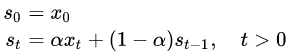

[https: // en.wikipedia.org / wiki / Exponential_smoothing](http://)


* smoothing 식

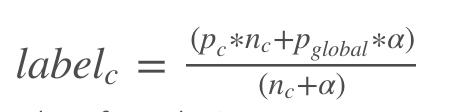

[https: // www.kaggle.com / vprokopev / mean - likelihood - encodings - a - comprehensive - study](http://)



### mean-encoding 적용 시켜주기.

In [ ]:
train_encoded, test_encoded = target_encode(train["ps_car_11_cat"],
                             test["ps_car_11_cat"],
                             target=train.target,
                             min_samples_leaf=100,
                             smoothing=10,
                             noise_level=0.01)

train['ps_car_11_cat_te'] = train_encoded
train.drop('ps_car_11_cat', axis=1, inplace=True)
meta.loc['ps_car_11_cat', 'keep'] = False  # drop 했으므로, meta 데이터를 업데이트 시켜준다.
test['ps_car_11_cat_te'] = test_encoded
test.drop('ps_car_11_cat', axis=1, inplace=True)

# Exploratory Data Visualization

## 1. 범주형 데이터 (Categorical variables)

범주형 데이터와 target=1 인 고객의 비율을 살펴본다.

In [ ]:
meta.to_csv('meta.csv')

v = meta[((meta.level == 'nominal') & (meta.keep))].index

for f in v:
    fig, ax = plt.subplots(figsize=(10,7))

    # 각 column 별 target=1 의 percentage 계산
    # 각 column 과 target 값을 따로 추출해서
    # 만들어진 dataframe 을 column 에서의 같은 값을 기준으로 groupby 를 하여, target 의 평균을 계산
    '''
            ps_car_09_cat  target
0                   2     0.0
1                   2     0.0
2                   2     0.0
3                   0     0.0
4                   0     0.0
...               ...     ...
216935              2     1.0
216936              2     1.0
216937              1     1.0
216938              2     1.0
216939              2     1.0
    '''
    # 위와 같이 만들어지면, 이를 ps_car_09_cat 에서 같은 값으로 groupby 하여 target 값을 평균낸다.
    cat_perc = train[[f, 'target']].groupby([f],as_index=False).mean()
    '''
    ps_car_09_cat    target
0             -1  0.226087
1              0  0.092161
2              1  0.149783
3              2  0.099636
4              3  0.096570
5              4  0.135338
    '''
    cat_perc.sort_values(by='target', ascending=False, inplace=True)
    # barplot
    # target mean 을 내림차순으로 그림
    sns.barplot(ax=ax, x=f, y='target', data=cat_perc, order=cat_perc[f])
    plt.ylabel('% target', fontsize=18)
    plt.xlabel(f, fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.show()

### insight

* 그래프를 통해 -1 값 (결측치 값)이 많을수록 고객이 보험을 청구할 가능성이 높다는 것을 볼 수 있다.
* 혹은 -1이 없는 경우 보험 청구 가능성이 없다는 것도 알 수 있다.
* 그러므로, -1이 유의미한 특징을 보여서, 최빈값으로 대체하는 대신 -1값을 그대로 두는게 바람직하다.
* 더 많은 insight은 https://www.kaggle.com/kongnyooong/porto-seguro-eda-for-korean 참고

In [ ]:
plt.clf() # plt 초기화

## 2. interval variable

* interval variable 끼리의 correlation 을 본다.
* heatmap을 사용하여 본다.

In [ ]:
def corr_heatmap(v):
    correlations = train[v].corr()

    fig, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(correlations, cmap='Blues', vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .75}, ax=ax)
    plt.show()
    
v = meta[(meta.level == 'interval') & (meta.keep)].index
corr_heatmap(v)

### insight

변수들 사이에 강한 correlation이 보인다.

* ps_reg_02 and ps_reg_03 (0.7)
* ps_car_12 and ps_car13 (0.67)
* ps_car_12 and ps_car14 (0.58)
* ps_car_13 and ps_car15 (0.67)

### pair plot

seaborn 에는 변수간의 (선형) 관계를 시각화 하는 몇 가지 편리한 plot이 있다. <br>
pairplot 을 이용해서 변수 간의 관계를 시각화 할 수 있다. <br>
heat map 에서 이미 상관관계가 높은 각 변수를 보여줬기 때문에 상관관계가 높은 변수를 위주로 pairplot 을 그린다. <br>

<br>

참고: 모든 데이터로 plot 하기 시간이 너무 많이 걸리므로 10% 만 sampling 해서 적용시켜준다.

In [ ]:
s = train.sample(frac=0.1) # 데이터의 10% sampling

#### 1. ps_reg_02 and ps_reg_03

In [ ]:
sns.lmplot(x='ps_reg_02', y='ps_reg_03', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

### insight

* 그래프로 볼 수 있듯이, 두 변수가 선형 관계를 이룬다는 것을 알 수 있다.
* hue parameter를 이용하여 traget=0과 target=1 의 regression line이 비슷함을 알 수 있다.

#### 2. ps_car_12 and ps_car_13

In [ ]:
sns.lmplot(x='ps_car_12', y='ps_car_13', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

#### 3. ps_car_12 and ps_car_14

In [ ]:
sns.lmplot(x='ps_car_12', y='ps_car_14', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

#### 4. ps_car_13 and ps_car_15

In [ ]:
sns.lmplot(x='ps_car_15', y='ps_car_13', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

### 유지할 상관 변수를 어떻게 결정할 수 있을까?

* 변수에 대해 PCA 를 수행하여 차원을 줄일 수 있다.
* 그러나 correlated variables가 적기 때문에, PCA를 진행하지 않는다.

## ordinal variables 에 대해 correlation 조사

In [ ]:
v = meta[(meta.level == 'ordinal') & (meta.keep)].index
corr_heatmap(v)

### insight

ordinal variable 의 경우 상관관계가 많지 않다.

# Feature engineering

## 1. encoding

* 고유값 (unique)이 많은 variable은 mean-encoding을 해줬다.
* 나머지 변수들에 대해서는 dummy variable을 만들어준다. (one-hot endcoding)
* categorical variable에 순서를 부여하지 않고, 고유값이 적어 차원이 많이 늘어나지 않는다.

In [ ]:
v = meta[(meta.level == 'nominal') & (meta.keep)].index
print('Before dummification we have {} variables in train'.format(train.shape[1]))
print('Before dummification we have {} variables in test'.format(test.shape[1]))
train = pd.get_dummies(train, columns=v, drop_first=True)
test = pd.get_dummies(test, columns=v, drop_first=True)

print('After dummification we have {} variables in train'.format(train.shape[1]))
print('After dummification we have {} variables in test'.format(test.shape[1]))

## 2. Creating interaction variables

사이킷런의 PolynomialFeatures를 사용하여 훈련 세트에 있는 각 특성을 제곱하여 새로운 특성으로 추가한 훈련 데이터를 만들어보자 <br>
<br>
Q : 2차항 변수를 만드는 이유는 ? 어떤경우에 ? <br>
A : 데이터들간의 형태가 비선형일때 데이터에 각 특성의 제곱을 추가해서 특성이 추가된 비선형 데이터를 선형회귀 모델로 훈련시키는 방법 <br>

* PolynomialFeatures 를 사용한다.

* 입력값 x를 다항식으로 변환 (x >> [1, x, x^2, x^3...])

* 열의 개수가 2개라면 (x1, x2 >> [1, x1, x2, x1^2, x2^2, x1x2])

* poly.get_feature_names를 통해 편하게 feature의 이름을 지정해줄 수 있다.

출처: https://www.kaggle.com/kongnyooong/porto-seguro-eda-for-korean

In [ ]:
v = meta[(meta.level == 'interval') & (meta.keep)].index
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
interactions = pd.DataFrame(data=poly.fit_transform(train[v]), columns=poly.get_feature_names(v))
interactions.drop(v, axis=1, inplace=True)  # 원래 column은 제거

### Parameter

1. degree: 차수
2. interaction_only: 상호작용 항만 출력 (x1, x2일 때 자신의 제곱항은 무시하고 x1x2 만 출력)
3. include_bias: 상수항 생성 여부

In [ ]:
# interaction variables를 train data와 합친다.

print('Before creating interactions we have {} variables in train'.format(train.shape[1]))
train = pd.concat([train, interactions], axis=1)
test = pd.concat([test, interactions], axis=1)
print('After creating interactions we have {} variables in train'.format(train.shape[1]))

# feature selection

분류 알고리즘이 keep 할 feature 를 선택하도록 하기도 하지만, <br>
우리가 선택해주는 방법도 있다. <br>
이는 분산이 0이거나 작은 feature를 제거해 준다.<br>
Sklearn에는 VarianceThreshold 를 이용하면 편리하게 제거할 수 있다.<br>
<br>
그러나, 이 데이터에서는 분산이 0인 변수가 없고,<br>
분산이 1% 미만인 feature를 제거하면 31개의 변수가 제거된다.<br>
feature 가 적은 상태인데, 31개의 feature를 지워버리면 더 feature가 없기 때문에,<br>
이 데이터에서는 적용하지 않는다.<br>
<br>
<br>
 Q : 분산이 작은 변수를 제거해야하는 이유 ?<br>
<br>
 A : 예측모델에서 중요한 특성이란, 타겟과의 상관관계가 큰 특성을 의미한다.<br>
    그런데 상관관계에 앞서 어떤 특성의 값 자체가 표본에 따라 그다지 변하지 않는다면,<br>
    예측에 별 도움이 되지 않을 가능성이 높다.<br>
    (ex. 남자를 상대로한 설문조사 데이터에서 남자 라는 성별특성은 무의미함.)<br>
    따라서, 표본 변화에 따른 데이터 값의 변화량 즉, 분산이 기준치보다낮은 특성은 제거하는것<br>
<br>
출처: https://www.kaggle.com/whtngus4759/porto-seguro-for-beginner

아래는 VarianceThreshold 사용 예시이다.

In [ ]:
selector = VarianceThreshold(threshold=0.01)
selector.fit(train.drop(['id', 'target'], axis=1)) # id 와 target 을 제외하고 fit 한다.

# get_support() 하면 True,False값이 나오는데 이중에서 False값만 반환하기위해 f함수지정
f = np.vectorize(lambda x : not x)

v = train.drop(['id','target'],axis=1).columns[f(selector.get_support())]

print('{} variables have too low variance.'.format(len(v)))
print('These variables are {}'.format(list(v)))

# Selecting features with a Random Forest and SelectFromModel

* 분산을 기반으로 feature를 선택하면 많은 변수를 잃게 된다.
* 그러나, 변수의 개수가 많지 않기 때문에 classifier 가 선택하도록 한다.

<br>

* sklearn 은 다른 feature selection 기능을 제공하는데,
* 이는 SelectFromModel 을 이용하여 classifier가 최상의 feature를 선택하도록 하는 것이다.
* 아래 방법은 Random Forest 를 이용한 방식이다.

여기서는 Random forest 의 feature importance 를 기준으로 feature selection을 진행한다. <br>
<br>
Sklearn의 SelectFromModel을 사용하면 유지할 변수 개수를 지정할 수 있습니다.<br>
<br>
feature importance 의 임계값을 정할 수도 있다.<br>
그러나 여기서는 단순하게 상위 50% 의 변수를 택한다.<br>

In [ ]:
X_train = train.drop(['id', 'target'], axis=1)
y_train = train['target']

id_test = test['id']

feat_labels = X_train.columns

rf = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1)

rf.fit(X_train, y_train)
importances = rf.feature_importances_

indices = np.argsort(rf.feature_importances_)[::-1]
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,feat_labels[indices[f]], importances[indices[f]]))

get_support 를 이용하여 사용할 데이터를 뽑아낸다.

In [ ]:
sfm = SelectFromModel(rf, threshold='median', prefit=True)
print('Number of features before selection: {}'.format(X_train.shape[1]))

n_features = sfm.transform(X_train).shape[1]
print('Number of features after selection: {}'.format(n_features))
selected_vars = list(feat_labels[sfm.get_support()])

train = train[selected_vars + ['target']]
test = test[selected_vars]

# feature scailing 

feature scailing 을 적용하면 더 잘 동작하는 경우도 있다.

In [ ]:
'''
train_without_target = train.drop(['target'],axis=1)

scaler = StandardScaler()
train_scaled = scaler.fit_transform(train.drop(['target'],axis=1))
train_scaled = pd.DataFrame(train_scaled, columns=train_without_target.columns, index=list(train.index.values))
train = pd.concat([train_scaled, train['target']], axis=1)

scaler_test = StandardScaler()
test_scaled = scaler_test.fit_transform(test)
test = pd.DataFrame(test_scaled, columns=test.columns, index=list(test.index.values))
'''

# training

Ensemble 을 이용하여 해 보았다.

In [ ]:
X = train.drop(['target'],axis=1).values
y = train['target'].values

X_test = test.values

### gini evaluation

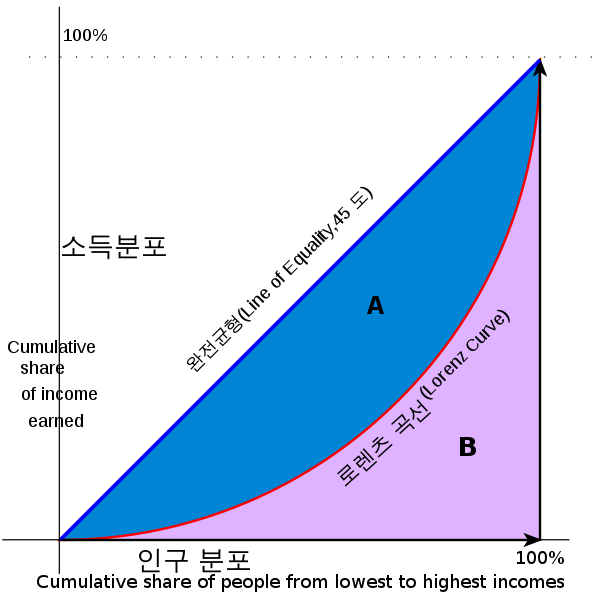

* A영역 = 로렌츠 곡선과 완전균형 대각선과의 사이 = 불평등 면적
* B영역 = 삼각형 전체면적 - A영역
* 지니계수 $${\displaystyle 지니계수 G={{A} \over {A+B}}}$$

* $$소득 완전평등 = 0 , {\displaystyle 지니계수 G={{0} \over {0+B}}}$$
* 로렌츠곡선이 완전균형 대각선에 수렴하여 일치될 때 A영역은 B영역에 의해 없어진다고 볼수있다.
* $$소득 완전불평등 = 1 , {\displaystyle G={{A} \over {A+0}}}$$
* 로렌츠곡선이 수직선에 수렴하여 일치될 때 B영역은 A영역에 의해 없어진다고 볼수있다.


<br>

출처: [https://ko.wikipedia.org/wiki/%EC%A7%80%EB%8B%88_%EA%B3%84%EC%88%98](https://ko.wikipedia.org/wiki/%EC%A7%80%EB%8B%88_%EA%B3%84%EC%88%98)

In [ ]:
def eval_gini(y_true, y_pred):
    # 실제 값과 예측 값이 동일한 크기인지 확인합니다 (다른 값으로 인해 오류가 발생 함).
    assert y_true.shape == y_pred.shape

    n_samples = y_true.shape[0] # 데이터 수
    L_mid = np.linspace(1 / n_samples, 1, n_samples) # 대각선 값
    # 1 / n_samples 에서 1 까지 n_samples 만큼의 개수의 수를 생성

    # 1) 예측 값에 대한 지니 계수
    pred_order = y_true[y_pred.argsort()] # y_pred 크기로 y_true 값 정렬
    L_pred = np.cumsum(pred_order) / np.sum(pred_order) # Lorentz Curve  # cumsum 은 누적합을 의미
    G_pred = np.sum(L_mid - L_pred) # 예측값에 대한 지니 계수 (A 영역)

    # 2) 예측이 완벽 할 때의 지니 계수
    true_order = y_true[y_true.argsort()] # y_pred 크기로 y_true 값 정렬
    L_true = np.cumsum(true_order) / np.sum(true_order) # Lorentz Curve
    G_true = np.sum(L_mid - L_true) # 예측이 완벽 할 때의 지니 계수 (A+B 영역)

    # 정규화 된 지니 계수
    return G_pred / G_true

def gini_lgb(preds, dtrain):
    labels = dtrain.get_label()
    return 'gini', eval_gini(labels, preds), True


def gini_xgb(preds, dtrain):
    labels = dtrain.get_label()
    return 'gini', eval_gini(labels, preds)

### Modeling

각 모델에 대해서 cross validation을 진행하고 <br>
LGBM 에 0.6 의 가중치를, XBG 에는 0.4의 가중치를 주어 Ensemble 학습을 한다. <br>

In [ ]:
from sklearn.model_selection import StratifiedKFold

# Stratified K Fold Cross-Verifier 만들기 (5등분 해 줌)
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1991)

#### 1. LGBM

In [ ]:
max_params_lgb = {'bagging_fraction': 0.8043696643500143, # 데이터를 샘플링하는 비율로, 트리가 커져서 과대적합되는 것을 제어한다.
 'feature_fraction': 0.6829323879981047, # 개별 트리를 학습할 때나다 무작위로 선택하는 피처의 비율
 'lambda_l1': 0.9264555612104627, # L1 규제 (클수록 과적합 감소)
 'lambda_l2': 0.9774233689434216, # L2 규제 (클수록 과적합 감소)
 'min_child_samples': 10, # 리프 노드가 되기 위한 최소한의 샘플 데이터 수
 'min_child_weight': 125.68433948868649, 
                  # 트리에서 추가적으로 가지를 나눌지 결정하기 위해 필요한 데이터들의 weight 총합 해당 값이 클수록 분할이 잘 안 일어난다.
 'num_leaves': 28, # 하나의 트리가 가질 수 있는 최대 리프 개수 
 'objective': 'binary', # 손실함수 정의
 'learning_rate': 0.01, # 학습률
 'bagging_freq': 1, # bagging 빈도
                  # 0은 bagging 비활성화를 의미하고 k는 k 반복마다 bagging을 수행함을 의미한다.
 'verbosity': 0, 
 'random_state': 1991}

import lightgbm as lgbm

# OOF-trained model 로 검증 데이터 대상 값을 예측하기 위한 1차원 확률 배열
oof_val_preds_lgb = np.zeros(X.shape[0])
# OOF-trained model 로 검증 데이터 대상 값을 예측하기 위한 1차원 확률 배열
oof_test_preds_lgb = np.zeros(X_test.shape[0])

# OOF 에 의한 Train, validate, and predict models
for idx, (train_idx, valid_idx) in enumerate(folds.split(X, y)):
    # The phrase that separates each fold.
    print('#' * 40, f'Fold {idx + 1} out of {folds.n_splits}', '#' * 40)

    # train data, valid data 설정
    X_train, y_train = X[train_idx], y[train_idx]  # Train data
    X_valid, y_valid = X[valid_idx], y[valid_idx]  # Valid data

    # Create lgbm dataset
    dtrain = lgbm.Dataset(X_train, y_train)  # lgbm train dataset
    dvalid = lgbm.Dataset(X_valid, y_valid)  # lgbm valid dataset

    # Train LightGBM
    lgb_model = lgbm.train(params=max_params_lgb,  # 최적의 Hyper-parameters
                           train_set=dtrain,  # Train data
                           num_boost_round=1500,  # boosting 반복 횟수
                           valid_sets=dvalid,  # model 성능 평가를 위한 Valid data
                           feval=gini_lgb,  # validation 을 위한 evaluation metrics
                           early_stopping_rounds=150,  # Early stopping 조건 (150 회 동안 loss의 감소가 없으면 학습 중단)
                           verbose_eval=100)

    # 모델의 성능이 가장 좋은 경우 boosting 반복 횟수
    best_iter = lgb_model.best_iteration
    # test data 를 이용한 predict probabilities
    # (predict 한 값들의 평균)
    oof_test_preds_lgb += lgb_model.predict(X_test,
                                            num_iteration=best_iter) / folds.n_splits
    # 모델 성능 평가를 위한 OOF 예측
    oof_val_preds_lgb[valid_idx] += lgb_model.predict(X_valid, num_iteration=best_iter)

    # OOF 예측에 대한 정규화된 지니 계수
    gini_score = eval_gini(y_valid, oof_val_preds_lgb[valid_idx])
    print(f'Fold {idx + 1} gini score: {gini_score}\n')


#### 2. XGboost

In [ ]:
max_params_xgb = {'colsample_bytree': 0.8927325521002059, # 트리 생성에 필요한 피처(칼럼)를 임의로 샘플링하는 데 사용된다.
                  # 매우 많은 피처가 있는 경우 과적합을 조정하는 데 사용된다.
 'gamma': 9.766883037651555, # 트리의 리프 노드를 추가적으로 나눌지를 결정할 최소 손실 감소 값이다.
                  # 해당 값보다 손실(loss) 이 감소된 경우에 리프 노드를 분리한다. 값이 클수록 과적합 감소 효과가 있다.
 'max_depth': 7, # 트리 기반 알고리즘의 max_depth 와 같다. 0을 지정하면 깊이 제한이 없다. max_depth가 높으면 과적합 가능서이 높다.
                  # 보통 3~10 사이의 값을 적용한다.
 'min_child_weight': 6.0577898395058085, 
                  # 트리에서 추가적으로 가지를 나눌지 결정하기 위해 필요한 데이터들의 weight 총합 해당 값이 클수록 분할이 잘 안 일어난다.
 'reg_alpha': 8.136089122187865, # L1 규제 (feature의 개수가 많을 경우 적용을 검토하며, 값이 클수록 과적합 감소 효과가 있다.)
 'reg_lambda': 1.385119327658532, # L2 규제 (feature의 개수가 많을 경우 적용을 검토하며, 값이 클수록 과적합 감소 효과가 있다.)
 'scale_pos_weight': 1.5142072116395773, # 특정 값으로 치우친 비대칭한 클래스로 구성된 데이터 세트의 균형을 유지하기 위한 파라미터이다.
 'subsample': 0.717425859940308, # 트리가 커져서 과적합되는 것을 제어하기 위해 데이터를 샘플링하는 비율을 지정한다.
 'objective': 'binary:logistic', # 손실함수 지정
 'learning_rate': 0.05, # 학습률
 'random_state': 1991}

import xgboost as xgb

# OOF-trained model 로 검증 데이터 대상 값을 예측하기 위한 1차원 확률 배열
oof_val_preds_xgb = np.zeros(X.shape[0])
# OOF-trained model 로 검증 데이터 대상 값을 예측하기 위한 1차원 확률 배열
oof_test_preds_xgb = np.zeros(X_test.shape[0])

# OOF 에 의한 Train, validate, and predict models
for idx, (train_idx, valid_idx) in enumerate(folds.split(X, y)):
    # The phrase that separates each fold.
    print('#' * 40, f'Fold {idx + 1} out of {folds.n_splits}', '#' * 40)

    # train data, valid data 설정
    X_train, y_train = X[train_idx], y[train_idx]
    X_valid, y_valid = X[valid_idx], y[valid_idx]

    # xgboost dmatrix 만들기
    dtrain = xgb.DMatrix(X_train, y_train)
    dvalid = xgb.DMatrix(X_valid, y_valid)
    dtest = xgb.DMatrix(X_test)

    watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

    xgb_model = xgb.train(params=max_params_xgb,
                          dtrain=dtrain,
                          num_boost_round=1000,
                          evals=watchlist,
                          maximize=True,
                          feval=gini_xgb,
                          early_stopping_rounds=150,
                          verbose_eval=100)

    # 모델의 성능이 가장 좋은 경우 boosting 반복 횟수
    best_iter = xgb_model.best_iteration
    # test data 를 이용한 predict probabilities
    # (predict 한 값들의 평균)
    oof_test_preds_xgb += xgb_model.predict(dtest,
                                            ntree_limit=best_iter) / folds.n_splits
    # 모델 성능 평가를 위한 OOF 예측
    oof_val_preds_xgb[valid_idx] += xgb_model.predict(dvalid, ntree_limit=best_iter)

    # OOF 예측에 대한 정규화된 지니 계수
    gini_score = eval_gini(y_valid, oof_val_preds_xgb[valid_idx])
    print(f'Fold {idx + 1} gini score: {gini_score}\n')

print('LightGBM OOF Gini Score:', eval_gini(y, oof_val_preds_lgb))
print('XGBoost OOF Gini Score:', eval_gini(y, oof_val_preds_xgb))

#### Ensemble prediction

In [ ]:
oof_test_preds = oof_test_preds_lgb * 0.6 + oof_test_preds_xgb * 0.4

#### submission

In [ ]:
sub = pd.DataFrame()
sub['id'] = id_test
sub['target'] = oof_test_preds

sub.set_index('id')

sub.to_csv('submission.csv', index=False)